# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles for 100 robot steps then it is moved into another random location.
- The data is not normalized in this experiment.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

        - (0, 0, 0.05)
        - (10, 10, 0.05)
        
- The simulator runs during 10 hours of simulation (~10 minutes in fast mode).

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


# First Experiment

In [2]:
csv_file = 'robot_info_dataset.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,1.050733,1.094226,308.240738,0.059450,0.344226,128.240516,1.061660,1.289745,0.990510,...,1.000384,1.083896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.052836,1.093243,311.136141,0.002103,-0.000982,2.895403,1.129972,1.214009,1.135844,...,0.993033,1.009313,0.068312,-0.075736,0.145334,0.327937,0.133375,0.140812,-0.007352,-0.074582
2,2,1.054507,1.091473,315.074322,0.001672,-0.001770,3.938181,1.185616,1.131318,1.019394,...,0.956272,0.944564,0.055645,-0.082692,-0.116450,0.110155,0.029906,-0.014191,-0.036761,-0.064750
3,3,1.056316,1.089796,319.070072,0.001809,-0.001677,3.995750,1.098113,1.103999,1.094631,...,0.881076,1.000029,-0.087503,-0.027318,0.075237,0.054568,-0.004316,-0.045687,-0.075196,0.055465
4,4,1.058129,1.088026,323.456321,0.001812,-0.001770,4.386249,1.327904,1.104746,1.123384,...,0.842176,0.892464,0.229791,0.000746,0.028753,-0.037511,0.034774,-0.001614,-0.038900,-0.107565


## Data pre-processing

The data collected 1384848 samples.

In [3]:
df.shape

(1757372, 23)

The data set contains some null values so they should be deleted from the samples.

In [4]:
df = df.dropna()

## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [5]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
sampled_df = df.sample(frac=1)

# separate inputs from outputs
inputs = sampled_df[['x', 'y', 'theta']]
targets = sampled_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:]
test_targets = targets[train_size:]

inputs.head()

,x,y,theta
895124,0.653357,1.063240,125.240654
1137400,0.987911,0.667243,216.936965
275170,1.422306,0.498192,119.875964
768628,0.249193,1.138638,148.239698
1101989,1.510360,0.441171,296.325189


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. One model per sensor will be created.

In [6]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(3,)))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [7]:
train_targets[['sensor_1']][0:10]

,sensor_1
895124,0.431865
1137400,1.009436
275170,0.953402
768628,0.378544
1101989,0.408048
1443261,0.456965
1600878,1.203640
1334891,1.307908
386037,1.465363
1531235,0.637126


In [8]:
def k_fold(sensor_number, num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[[sensor_number]][i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[[sensor_number]][:i * num_val_samples],
             train_targets[[sensor_number]][(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=64, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse


In [10]:
histories, nmse = k_fold('sensor_3', 50, 3)

processing fold # 0
Train on 600514 samples, validate on 300257 samples
Epoch 1/50
600514/600514 [==============================] - 29s 49us/step - loss: 0.2550 - mae: 0.3006 - val_loss: 0.2141 - val_mae: 0.3103
Epoch 2/50
600514/600514 [==============================] - 26s 43us/step - loss: 0.0365 - mae: 0.1363 - val_loss: 0.1581 - val_mae: 0.2660
Epoch 3/50
600514/600514 [==============================] - 26s 43us/step - loss: 0.0229 - mae: 0.1068 - val_loss: 0.1301 - val_mae: 0.2627
Epoch 4/50
600514/600514 [==============================] - 27s 45us/step - loss: 0.0172 - mae: 0.0920 - val_loss: 0.0101 - val_mae: 0.0734
Epoch 5/50
600514/600514 [==============================] - 29s 49us/step - loss: 0.0141 - mae: 0.0828 - val_loss: 0.0382 - val_mae: 0.1248
Epoch 6/50
600514/600514 [==============================] - 27s 45us/step - loss: 0.0120 - mae: 0.0764 - val_loss: 0.0154 - val_mae: 0.0911
Epoch 7/50
600514/600514 [==============================] - 28s 47us/step - loss: 0.0105

Epoch 16/50
600514/600514 [==============================] - 25s 41us/step - loss: 0.0067 - mae: 0.0562 - val_loss: 0.0053 - val_mae: 0.0500
Epoch 17/50
600514/600514 [==============================] - 24s 40us/step - loss: 0.0066 - mae: 0.0558 - val_loss: 0.0051 - val_mae: 0.0515
Epoch 18/50
600514/600514 [==============================] - 25s 41us/step - loss: 0.0065 - mae: 0.0554 - val_loss: 0.0089 - val_mae: 0.0698
Epoch 19/50
600514/600514 [==============================] - 24s 40us/step - loss: 0.0064 - mae: 0.0549 - val_loss: 0.0061 - val_mae: 0.0520
Epoch 20/50
600514/600514 [==============================] - 24s 40us/step - loss: 0.0062 - mae: 0.0544 - val_loss: 0.0072 - val_mae: 0.0640
Epoch 21/50
600514/600514 [==============================] - 23s 39us/step - loss: 0.0061 - mae: 0.0540 - val_loss: 0.0067 - val_mae: 0.0578
Epoch 22/50
600514/600514 [==============================] - 24s 41us/step - loss: 0.0061 - mae: 0.0537 - val_loss: 0.0070 - val_mae: 0.0653
Epoch 23/50
6

NMSE: 
0.023243289122821854


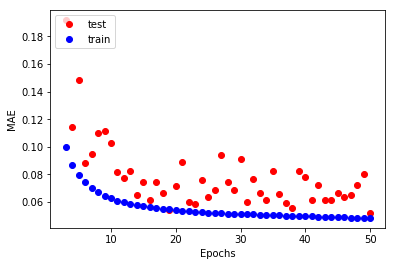

In [12]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 50
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


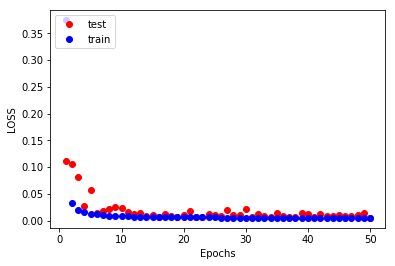

In [14]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [9]:
model = get_model()

history = model.fit(inputs, targets[['sensor_5']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_5.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1757371/1757371 [==============================] - 55s 31us/step - loss: 0.1082 - mae: 0.1700 0s - loss: 0.1094
Epoch 2/50
1757371/1757371 [==============================] - 61s 35us/step - loss: 0.0145 - mae: 0.0837
Epoch 3/50
1757371/1757371 [==============================] - 59s 34us/step - loss: 0.0098 - mae: 0.0681
Epoch 4/50
1757371/1757371 [==============================] - 62s 35us/step - loss: 0.0078 - mae: 0.0606
Epoch 5/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0069 - mae: 0.0570
Epoch 6/50
1757371/1757371 [==============================] - 54s 31us/step - loss: 0.0066 - mae: 0.0554
Epoch 7/50
1757371/1757371 [==============================] - 53s 30us/step - loss: 0.0063 - mae: 0.0540
Epoch 8/50
1757371/1757371 [==============================] - 53s 30us/step - loss: 0.0060 - mae: 0.0528
Epoch 9/50
1757371/175

In [10]:
model = get_model()

history = model.fit(inputs, targets[['sensor_6']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_6.h5")

Epoch 1/50
1757371/1757371 [==============================] - 54s 31us/step - loss: 0.1358 - mae: 0.1675 0s - loss: 0.1370 - m
Epoch 2/50
1757371/1757371 [==============================] - 53s 30us/step - loss: 0.0106 - mae: 0.0723
Epoch 3/50
1757371/1757371 [==============================] - 54s 31us/step - loss: 0.0083 - mae: 0.0640
Epoch 4/50
1757371/1757371 [==============================] - 54s 31us/step - loss: 0.0074 - mae: 0.0604
Epoch 5/50
1757371/1757371 [==============================] - 55s 31us/step - loss: 0.0068 - mae: 0.0578
Epoch 6/50
1757371/1757371 [==============================] - 55s 31us/step - loss: 0.0063 - mae: 0.0557 0s - loss: 0.00
Epoch 7/50
1757371/1757371 [==============================] - 54s 30us/step - loss: 0.0060 - mae: 0.0539
Epoch 8/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0057 - mae: 0.0526 3s - loss: 0.0057 - ma - ETA: 1s - loss: 
Epoch 9/50
1757371/1757371 [==============================] - 54s 31us/step - lo

In [11]:
model = get_model()

history = model.fit(inputs, targets[['sensor_7']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_7.h5")

Epoch 1/50
1757371/1757371 [==============================] - 55s 31us/step - loss: 0.1274 - mae: 0.1858 0s - loss: 
Epoch 2/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0275 - mae: 0.0880
Epoch 3/50
1757371/1757371 [==============================] - 55s 32us/step - loss: 0.0219 - mae: 0.0728
Epoch 4/50
1757371/1757371 [==============================] - 55s 31us/step - loss: 0.0198 - mae: 0.0660 0s - loss: 0.0198 - mae: 
Epoch 5/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0189 - mae: 0.0631 0s - loss: 0.0189 - ma
Epoch 6/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0184 - mae: 0.0612
Epoch 7/50
1757371/1757371 [==============================] - 54s 31us/step - loss: 0.0177 - mae: 0.0589
Epoch 8/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0174 - mae: 0.0577
Epoch 9/50
1757371/1757371 [==============================] - 54s 31us/step - loss: 0.0172 - mae: 0

In [12]:
model = get_model()
history = model.fit(inputs, targets[['sensor_8']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_8.h5")

Epoch 1/50
1757371/1757371 [==============================] - 57s 32us/step - loss: 0.1538 - mae: 0.1891
Epoch 2/50
1757371/1757371 [==============================] - 57s 32us/step - loss: 0.1027 - mae: 0.1129
Epoch 3/50
1757371/1757371 [==============================] - 55s 32us/step - loss: 0.0963 - mae: 0.0980 0s - loss: 0.0963
Epoch 4/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0931 - mae: 0.0908
Epoch 5/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0914 - mae: 0.0861
Epoch 6/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0911 - mae: 0.0858
Epoch 7/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0910 - mae: 0.0847
Epoch 8/50
1757371/1757371 [==============================] - 57s 32us/step - loss: 0.0904 - mae: 0.0826 0s - loss: 
Epoch 9/50
1757371/1757371 [==============================] - 57s 33us/step - loss: 0.0899 - mae: 0.0815
Epoch 10/50
1757371/17573

In [13]:
model = get_model()

history = model.fit(inputs, targets[['sensor_1']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_1.h5")

Epoch 1/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.1624 - mae: 0.1863
Epoch 2/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0964 - mae: 0.1004
Epoch 3/50
1757371/1757371 [==============================] - 57s 32us/step - loss: 0.0906 - mae: 0.0843
Epoch 4/50
1757371/1757371 [==============================] - 57s 32us/step - loss: 0.0901 - mae: 0.0831
Epoch 5/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0905 - mae: 0.0839
Epoch 6/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0904 - mae: 0.0838 0s - loss: 0.0904 - ma
Epoch 7/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0907 - mae: 0.0846
Epoch 8/50
1757371/1757371 [==============================] - 57s 32us/step - loss: 0.0907 - mae: 0.0849 - ETA: 2 - ETA: 0s - loss: 0.0
Epoch 9/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0902 - mae: 0.0840
E

In [14]:
model = get_model()

history = model.fit(inputs, targets[['sensor_2']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_2.h5")

Epoch 1/50
1757371/1757371 [==============================] - 59s 33us/step - loss: 0.1533 - mae: 0.1860
Epoch 2/50
1757371/1757371 [==============================] - 59s 34us/step - loss: 0.0216 - mae: 0.0800
Epoch 3/50
1757371/1757371 [==============================] - 59s 34us/step - loss: 0.0178 - mae: 0.0668
Epoch 4/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0165 - mae: 0.0618
Epoch 5/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0157 - mae: 0.0588
Epoch 6/50
1757371/1757371 [==============================] - 60s 34us/step - loss: 0.0152 - mae: 0.0568
Epoch 7/50
1757371/1757371 [==============================] - 60s 34us/step - loss: 0.0148 - mae: 0.0551
Epoch 8/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0146 - mae: 0.0541 0s - loss: 0.0146 - m
Epoch 9/50
1757371/1757371 [==============================] - 60s 34us/step - loss: 0.0144 - mae: 0.0533
Epoch 10/50
1757371/1757371 [====

In [15]:
model = get_model()

history = model.fit(inputs, targets[['sensor_3']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_3.h5")

Epoch 1/50
1757371/1757371 [==============================] - 60s 34us/step - loss: 0.0322 - mae: 0.1187
Epoch 2/50
1757371/1757371 [==============================] - 60s 34us/step - loss: 0.0121 - mae: 0.0759
Epoch 3/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0094 - mae: 0.0664
Epoch 4/50
1757371/1757371 [==============================] - 61s 34us/step - loss: 0.0081 - mae: 0.0618
Epoch 5/50
1757371/1757371 [==============================] - 59s 34us/step - loss: 0.0073 - mae: 0.0586
Epoch 6/50
1757371/1757371 [==============================] - 61s 34us/step - loss: 0.0068 - mae: 0.0565
Epoch 7/50
1757371/1757371 [==============================] - 60s 34us/step - loss: 0.0064 - mae: 0.0547
Epoch 8/50
1757371/1757371 [==============================] - 58s 33us/step - loss: 0.0061 - mae: 0.0535 1s - lo
Epoch 9/50
1757371/1757371 [==============================] - 59s 33us/step - loss: 0.0059 - mae: 0.0524
Epoch 10/50
1757371/1757371 [==================

In [16]:
model = get_model()

history = model.fit(inputs, targets[['sensor_4']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_4.h5")

Epoch 1/50
1757371/1757371 [==============================] - 62s 35us/step - loss: 0.0673 - mae: 0.1653
Epoch 2/50
1757371/1757371 [==============================] - 60s 34us/step - loss: 0.0149 - mae: 0.0838
Epoch 3/50
1757371/1757371 [==============================] - 61s 35us/step - loss: 0.0106 - mae: 0.0702
Epoch 4/50
1757371/1757371 [==============================] - 61s 35us/step - loss: 0.0087 - mae: 0.0634
Epoch 5/50
1757371/1757371 [==============================] - 62s 35us/step - loss: 0.0077 - mae: 0.0593
Epoch 6/50
1757371/1757371 [==============================] - 56s 32us/step - loss: 0.0071 - mae: 0.0566
Epoch 7/50
1757371/1757371 [==============================] - 62s 35us/step - loss: 0.0067 - mae: 0.0546 1s
Epoch 8/50
1757371/1757371 [==============================] - 62s 35us/step - loss: 0.0064 - mae: 0.0532
Epoch 9/50
1757371/1757371 [==============================] - 61s 35us/step - loss: 0.0061 - mae: 0.0521
Epoch 10/50
1757371/1757371 [=======================